In [3]:
import numpy as np
import torch
import pyro
import torch.distributions as dist
import pyro.distributions as pdist
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyro import poutine

from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer import NUTS, MCMC
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro import poutine
from torch.distributions import constraints
from pyro.ops.indexing import Vindex

### About Empirical:

In [4]:
emp = pdist.Empirical(torch.tensor([0, 1, 0, 0]), torch.ones(4)*0.5)

In [5]:
site = emp.sample()
print("site: ", site)
print("exp(emp.log_prob(site)): ", torch.exp(emp.log_prob(site)))
print("emp.sites:", emp.enumerate_support())

site:  tensor(0)
exp(emp.log_prob(site)):  tensor(0.7500)
emp.sites: tensor([0, 1, 0, 0])


### Likelihood inference

Model, whose params want to infer: 

In [6]:
def model5():
    # transition:
    # this will be infered (when no conditions given):
    log = torch.ones(10)*(-3.)
    log[0:3] = torch.ones(3)*(-1.)
    log[2] = torch.ones(1)*(-0.1)

    p_a = pyro.sample("p_a", pdist.Empirical(torch.linspace(0, 1, 10),
                                             log))
    a = pyro.sample("a", pdist.Binomial(2, p_a))
    # a = pyro.sample("a", pdist.Categorical(torch.tensor([0.33, 0.33, 0.33])))
    p_b = [0.6, 0.3, 0.1]

    d = pdist.Bernoulli(p_b[a.type(torch.long)])
    
    # log_p will still work correctly in this case because it
    # use d.log_p, and d has probability p_b[a]
    # so p(b=0, a=1) = p(b=0|a=1)*p(a=1) = 0.7*(2*p*(1-p))
    # = 0.7*2*0.5*0.5 = 0.7*0.5 = 0.35
    b = pyro.sample("b", d)
    
    return b

#### Core of likelihood weighting alg: 

In [7]:
def sequential_discrete_marginal(model, data, site_name="_RETURN"):
    '''
    REF: http://pyro.ai/examples/effect_handlers.html#Example:-exact-inference-via-sequential-enumeration
    '''
    from six.moves import queue  # queue data structures
    q = queue.Queue()  # Instantiate a first-in first-out queue
    q.put(poutine.Trace())  # seed the queue with an empty trace

    # as before, we fix the values of observed random variables with poutine.condition
    # assuming data is a dictionary whose keys are names of sample sites in model
    conditioned_model = poutine.condition(model, data=data)

    # we wrap the conditioned model in a poutine.queue,
    # which repeatedly pushes and pops partially completed executions from a Queue()
    # to perform breadth-first enumeration over the set of values of all discrete sample sites in model
    enum_model = poutine.queue(conditioned_model, queue=q)

    # actually perform the enumeration by repeatedly tracing enum_model
    # and accumulate samples and trace log-probabilities for postprocessing
    samples, log_weights = [], []
    while not q.empty():
        trace = poutine.trace(enum_model).get_trace()
        samples.append(trace.nodes[site_name]["value"])
        log_weights.append(trace.log_prob_sum())
        # print(dict([(name, trace.nodes[name]) for name in ["a", "b"]]))
    '''
    nsamples = []
    nlogs = []
    for idx, s in enumerate(samples):
      if(s not in nsamples):
        nsamples.append(s)
        nlogs.append(torch.exp(log_weights[idx]))
      else:
        nlogs[nsamples.index(s)] += torch.exp(log_weights[idx])
    '''
    samples = torch.stack(samples, 0)
    log_weights = torch.stack(log_weights, 0)
    # print("samples:")
    #print(samples)
    #print("log_weights:")
    #print(log_weights)
    # print("nsamples:")
    # print(nsamples)
    # print("nlogs:")
    #print(nlogs)
    # print("log_wieghts:")
    # print(torch.exp(torch.tensor(log_weights)))  
    # we take the samples and log-joints and turn them into a histogram:
    # samples = torch.stack(nsamples, 0)
    # log_weights = torch.log(torch.stack(nlogs, 0))
    # print("samples:")
    # print(samples)
    # return(trace.nodes[site_name]["fn"].enumerate_support(), pdist.util.logsumexp(log_weights, dim=0))
    return(samples, log_weights)

    # log_weights = log_weights - pdist.util.logsumexp(log_weights, dim=0)
    
    return(pdist.Empirical(samples, log_weights), log_weights)

#### Inference:

In [9]:
# emp = sequential_discrete_marginal(model4, {"b": data}, "a")
# 3 for "a":
lw = torch.zeros(60)
emp = pdist.Binomial(2, 0.5)

data = [1]
# for d in torch.tensor([0.,1., 1., 1.]):
# only one step required:
for n in range(1):
  for d in data[:1]:
    # emp, log_weights = sequential_discrete_marginal(model4, emp, {"b": d}, "a")
    # samples, log_weights = sequential_discrete_marginal(model5, {"b": d}, "p_a")
    samples, log_weights = sequential_discrete_marginal(model5, {}, "p_a")
    
    
    lw += log_weights
    # print(log_weights)
# P(a) = \sum_{h}(P(a, h))
lw= lw - pdist.util.logsumexp(lw, dim=0)
# print("lw:")
# print(lw)
# lw = -1.* lw/lw.sum()
# lw = lw - pdist.util.logsumexp(lw, dim=0)
# print("samples:")
# print(samples)
# FOR factorization P(a) = \sum_{h}(P(a, h)) too:
nsamples = []
nlogs = []
for idx, s in enumerate(samples):
  if(s not in nsamples):
    nsamples.append(s)
    nlogs.append(torch.exp(lw[idx]))
  else:
    nlogs[nsamples.index(s)] += torch.exp(lw[idx])
print("nsamles:")
print(nsamples)
print("nlogs:")
print(nlogs)
print("best: ", nsamples[nlogs.index(max(nlogs))])
# END FOR

# print('results for "a":')
# print(lw)
# print("with observations:")
# print([0.,1., 1., 1.])
emp = pdist.Empirical(samples, lw)
print("mean: ",emp.mean)

nsamles:
[tensor(0.), tensor(0.1111), tensor(0.2222), tensor(0.3333), tensor(0.4444), tensor(0.5556), tensor(0.6667), tensor(0.7778), tensor(0.8889), tensor(1.)]
nlogs:
[tensor(0.1849), tensor(0.1849), tensor(0.4549), tensor(0.0250), tensor(0.0250), tensor(0.0250), tensor(0.0250), tensor(0.0250), tensor(0.0250), tensor(0.0250)]
best:  tensor(0.2222)
mean:  tensor(0.2384)


#### Results, collected from `Empirical` and `nlogs` are same:

nlogs:
[tensor(0.1849), tensor(0.1849), tensor(0.4549), tensor(0.0250), tensor(0.0250), tensor(0.0250), tensor(0.0250), tensor(0.0250), tensor(0.0250), tensor(0.0250)]


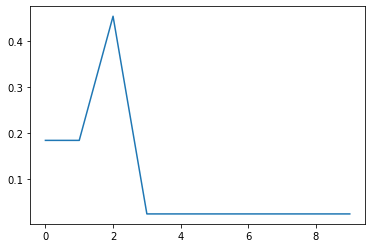

In [10]:
print("nlogs:")
print(nlogs)
plt.plot(torch.tensor(nlogs))